# TOMM40 importomics

This Jupyter notebok is part of a book chapter demonstrating the data analysis for mass spectrometry-based analysis of mitochondrial protein translocation mutants and interactome studies.
Data analysis relies on the autoprot software available at https://github.com/ag-warscheid/autoprot.

Author: Julian Bender, Warscheid Lab, Chair of Biochemistry II, University of Würzburg

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from autoprot_dev import analysis as ana
from autoprot_dev import preprocessing as pp
from autoprot_dev import visualization as vis

/opt/tljh/user/envs/autoprot/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Loading required package: rrcovNA
Loading required package: rrcov
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.7-2)

Scalable Robust Estimators with High Breakdown Point for
Incomplete Data (version 0.4-15)

Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: BiocManager
Bioconductor version '3.16' is out-of-date; the current release version '3.18'
  is ava

## Import and cleaning of data

The MaxQuant results files are parsed and reverse as well as potential contaminant entries are removed.
The additional column "Gene names first" that is eventually added, serves for the annotatin of the final volcano plot.

In [2]:
# parse the results file
pg = pp.read_csv("../MitoCop_main_search_proteinGroups.txt")
# remove reverse and potential contaminant entries
pg = pp.cleaning(pg, file="proteinGroups.txt")
# generate column for volcano plot annotation
pg["Gene names first"] = pg["Gene names"].str.split(";").str[0]

12461 rows before filter operation.
12461 rows after filter operation.


In [3]:
# select the ratio columns from the proteinGroups dataframe
ratio_cols = pg.filter(regex="Ratio H/L TOMM40").columns.tolist()
ratio_cols

['Ratio H/L TOMM40KD_1',
 'Ratio H/L TOMM40KD_2',
 'Ratio H/L TOMM40KD_3',
 'Ratio H/L TOMM40KD_4']

In [4]:
# filter for at least 2 valid values across 4 replicates
pg = pp.filter_vv(pg, [ratio_cols], n=2)

12461 rows before filter operation.
6693 rows after filter operation.


In [5]:
# log transform the ratio columns.
# the invert kwarg indicates which replicates are label switches (i.e. must be multiplied with -1 to get the correct ratio)
pg, log_ratio_cols = pp.log(pg, ratio_cols, invert=(1, 1, -1, -1), return_cols=True)

As a control for the correct inversion of ratio columns, we plot the ratios of all proteins and highlight the knocked-down protein TOMM40 and its close interactor TIMM21.
The log ratio of these two proteins should be negative if we correctly inverted the ratios.

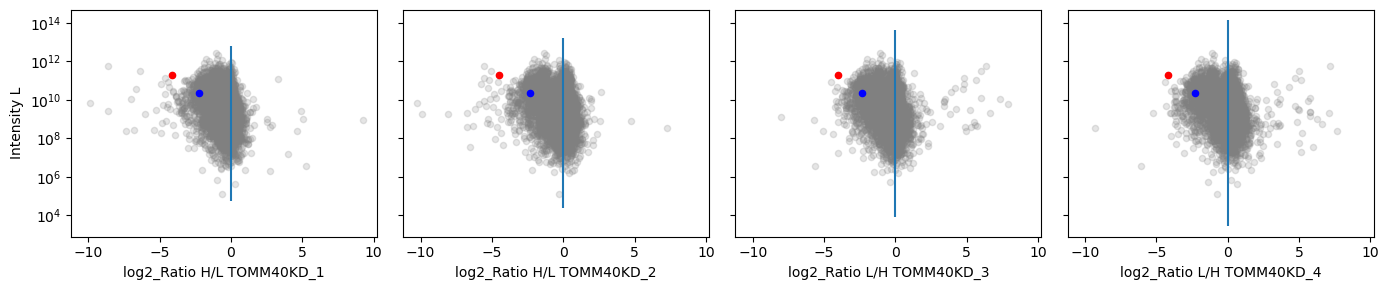

In [6]:
# figure object for plotting
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(14, 3), sharey=True, sharex=True)

# plot every replicate on a separate subplot
for ax, ratio in zip(axs, log_ratio_cols):
    pg.plot(
        kind="scatter",
        ax=ax,
        x=ratio,
        y="Intensity L",
        color="grey",
        alpha=0.2,
        logy=True,
    )

    pg[pg["Gene names"] == "TOMM40"].plot(
        kind="scatter", ax=ax, x=ratio, y="Intensity L", color="red", logy=True
    )

    pg[pg["Gene names"].str.contains("TIMM21", na=False)].plot(
        kind="scatter", ax=ax, x=ratio, y="Intensity L", color="blue", logy=True
    )

    ymin, ymax = ax.get_ylim()
    ax.vlines(0, ymin, ymax)

# nicer figures
plt.tight_layout()
# save the result
plt.savefig("importomics_fig1.pdf")

## Normalisation
### Median normalisation

Differences in sample treatment and/or loading can shift the ratios between replicates in a systematic fashion. This will impair downstream statistical analysis that tests if the separate protein groups behave similarly in all replicates.
Normalisation corrects for these systematic effects by shifting the log ratio distributions.
To account for loading differences, we start with a median normalisation that shifts the medians of the repliates to the median of medians between replicates.

In [7]:
# median normalisation
mnorm_cols = []
for col in log_ratio_cols:
    # calculate the correction factor
    median_shift = pg[col].median() - pg[log_ratio_cols].median().median()
    # generate a new column name for the median-corrected ratios
    new_col = col + "_mnorm"
    mnorm_cols.append(new_col)
    # apply the correction and store in the new column
    pg[new_col] = pg[col] - median_shift

mnorm_cols

['log2_Ratio H/L TOMM40KD_1_mnorm',
 'log2_Ratio H/L TOMM40KD_2_mnorm',
 'log2_Ratio L/H TOMM40KD_3_mnorm',
 'log2_Ratio L/H TOMM40KD_4_mnorm']

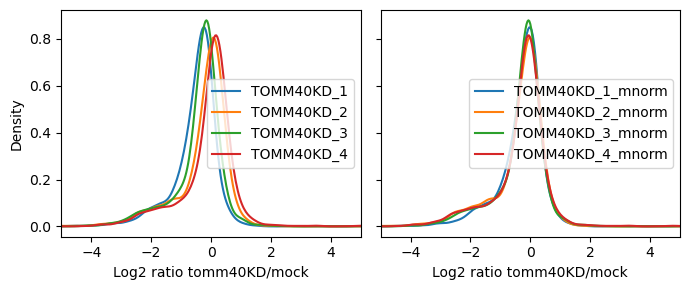

In [8]:
# visualisation of the effect of median normalisation
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7, 3), sharex=True, sharey=True)

# plot kernel density plots to show the different distributions
pg[log_ratio_cols].plot(kind="kde", ax=axs[0])
pg[mnorm_cols].plot(kind="kde", ax=axs[1])

# shorten labels
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    labels = [x.split(" ")[-1] for x in labels]

    ax.legend(handles, labels)
    ax.set_xlabel("Log2 ratio tomm40KD/mock")
    ax.set_xlim((-5, 5))

# nice figures and save result
plt.tight_layout()
plt.savefig("importomics_fig2.pdf")
plt.show()

## Statistical analysis
For statistical analysis, conventional t-tests have long been used (and are still used today). The pre-processed, normalised ratio distribution should produce a similar result when analysed with a t-test. Here we want ot focus on more recent linear models for statistical analyiss.
### Linear models
In contrast to conventional t-tests, linear models take global patterns into account and can include information for example about label-switches.
To this end, we generate a custom design file which represents the variable space in which the experimental data points are projected and in which regression is performed.
If the design matrix contains a row of categorial 1s, this row is identical for every condition and hence corresponds to the intercept of the linear regression.
The presence of a label switch can be indicated by values of -1 vs. 1 in the design matrix. 

In [9]:
custom_design = pd.DataFrame({"treatment": [1, 1, 1, 1], "labelswitch": [1, 1, -1, -1]})

custom_design.to_csv("custom_design.tsv", sep="\t", index=False)

custom_design

,treatment,labelswitch
0,1,1
1,1,1
2,1,-1
3,1,-1


Extracting the coefficient corresponding to each column in the design matrix (i.e. treatment of labelswitch) extracts the corresponding P values.

In [10]:
pg = ana.limma(
    pg, mnorm_cols, custom_design="custom_design.tsv", coef="treatment", cond="_limma"
)

pg = ana.limma(
    pg,
    mnorm_cols,
    custom_design="custom_design.tsv",
    coef="labelswitch",
    cond="_limma_ls",
)

LIMMA: Assuming a custom design test with:
Design specified at custom_design.tsv
Columns: log2_Ratio H/L TOMM40KD_1_mnorm
	log2_Ratio H/L TOMM40KD_2_mnorm
	log2_Ratio L/H TOMM40KD_3_mnorm
	log2_Ratio L/H TOMM40KD_4_mnorm
Using design matrix:

|    |   treatment |   labelswitch |
|---:|------------:|--------------:|
|  0 |           1 |             1 |
|  1 |           1 |             1 |
|  2 |           1 |            -1 |
|  3 |           1 |            -1 |
LIMMA: Assuming a custom design test with:
Design specified at custom_design.tsv
Columns: log2_Ratio H/L TOMM40KD_1_mnorm
	log2_Ratio H/L TOMM40KD_2_mnorm
	log2_Ratio L/H TOMM40KD_3_mnorm
	log2_Ratio L/H TOMM40KD_4_mnorm
Using design matrix:

|    |   treatment |   labelswitch |
|---:|------------:|--------------:|
|  0 |           1 |             1 |
|  1 |           1 |             1 |
|  2 |           1 |            -1 |
|  3 |           1 |            -1 |


Here we plot the P values as histogram. The values corresponding to the label switch are all very high indicating that the label switch had only a minor effect on the total outcome of the experiment.
In contrast, the P values for the intercept coefficient (treatment) are very small, indicating that the overall ratios are significantly different from zero.

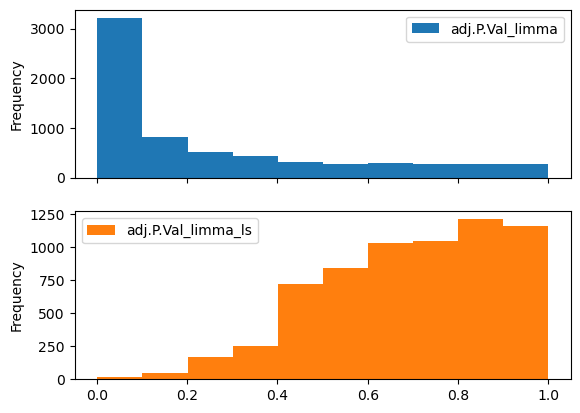

In [11]:
pg.filter(regex="adj\.P\.").plot(kind="hist", subplots=True)

plt.savefig("importomics_fig3.pdf")

plt.show()

## Visualisation

The most common visulisation for quantitiatve AP-MS results is a volcano plot that depicts the average enrichment on the x-axis vs. the statistical significance of the enrichment on the y-axis. Protein groups falling into the upper right quadrant are significantly enriched and are promising targets for biological validation

### Volcano plot

No kwargs provided for highlights. Using default values.


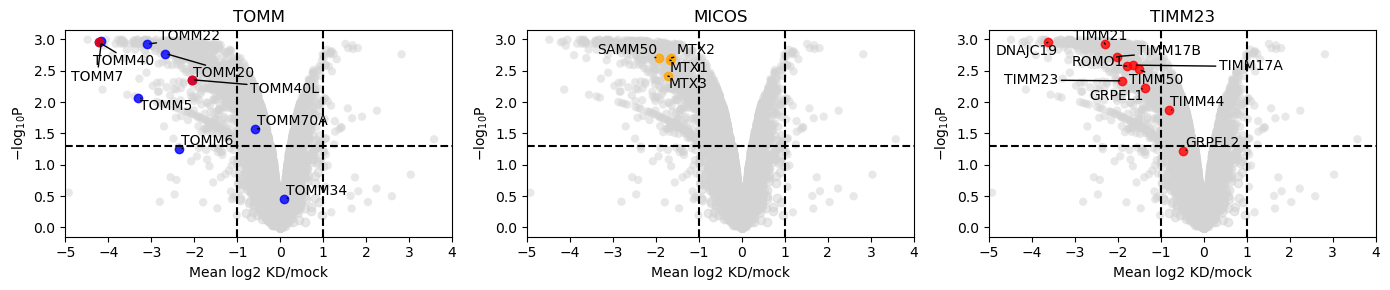

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 3), sharex=True)

highlight_bait = pg[pg["Gene names"].str.contains("TOMM40", na=False)].index
kwargs_bait = {"color": "red"}

highlight_tomm = pg[pg["Gene names"].str.contains("TOMM", na=False)].index
kwargs_tomm = {"color": "blue"}

highlight_micos = pg[
    pg["Gene names"].str.match(".*MTX2.*|.*MTX1.*|.*SAMM50.*|.*MTX3.*", na=False)
].index

highlight_timm23 = pg[
    pg["Gene names"].str.match(
        ".*TIMM21.*|.*DNAJC19.*|.*TIMM17A.*|.*ROMO1.*|.*TIMM50.*|.*HSP70.*|.*TIMM17B.*|.*GRPEL1.*|.*TIMM44.*|.*TIMM23.*|.*GRPEL2",
        na=False,
    )
].index

axs[0].set_xlim(-5, 4)
axs[0].set_title("TOMM")

# this wrapper function produces the actual volcano plot
vis.volcano(
    pg,
    log_fc_colname="logFC_limma",  # colname from which the x values are taken
    p_colname="adj.P.Val_limma",  # same for the y values
    log_fc_thresh=1,  # a threshold of 4-fold enrichment is typically chosen
    kwargs_both_sig={"color": "lightgrey", "edgecolor": "none"},
    kwargs_p_sig={"color": "lightgrey", "edgecolor": "none"},
    kwargs_log_fc_sig={"color": "lightgrey", "edgecolor": "none"},
    show_legend=False,
    ax=axs[0],
    show_caption=False,
    annotate="highlight",
    highlight=[highlight_tomm, highlight_bait],
    kwargs_highlight=[kwargs_tomm, kwargs_bait],
)

axs[0].set_xlabel("Mean log2 KD/mock")
axs[1].set_title("MICOS")

# MICOS
vis.volcano(
    pg,
    log_fc_colname="logFC_limma",  # colname from which the x values are taken
    p_colname="adj.P.Val_limma",  # same for the y values
    log_fc_thresh=1,  # a threshold of 4-fold enrichment is typically chosen
    kwargs_both_sig={"color": "lightgrey", "edgecolor": "none"},
    kwargs_p_sig={"color": "lightgrey", "edgecolor": "none"},
    kwargs_log_fc_sig={"color": "lightgrey", "edgecolor": "none"},
    show_legend=False,
    ax=axs[1],
    show_caption=False,
    annotate="highlight",
    highlight=highlight_micos,
)

axs[1].set_xlabel("Mean log2 KD/mock")
axs[2].set_title("TIMM23")

# TIMM23
vis.volcano(
    pg,
    log_fc_colname="logFC_limma",  # colname from which the x values are taken
    p_colname="adj.P.Val_limma",  # same for the y values
    log_fc_thresh=1,  # a threshold of 4-fold enrichment is typically chosen
    kwargs_both_sig={"color": "lightgrey", "edgecolor": "none"},
    kwargs_p_sig={"color": "lightgrey", "edgecolor": "none"},
    kwargs_log_fc_sig={"color": "lightgrey", "edgecolor": "none"},
    show_legend=False,
    ax=axs[2],
    show_caption=False,
    annotate="highlight",
    highlight=highlight_timm23,
    kwargs_highlight={"color": "red"},
)

axs[2].set_xlabel("Mean log2 KD/mock")

plt.tight_layout()

plt.savefig("importomics_fig4.pdf")
plt.show()

## Functional analysis
As the effect of TOMM40-KD is hampering the import of mitochondrial proteins, this section showcases how significantly (in this case) depleted proteins can be functionally annotated.
Therefore we compare these genes with all genes identified in the analysis. **Important**: When performing functional annotation on enriched samples, never use the total proteome as reference but the enriched subset.

We use the GProfiler API to perform the enrichment analysis (https://biit.cs.ut.ee/gprofiler/gost) completely from Python. The resulting table contains the significantly enriched terms from several sources which we filter and display as bar plots.

In [13]:
# extract the genes significantly downregulated after TOMM40 KD
signficantly_downregulated = (
    pg.loc[
        (pg["adj.P.Val_limma"] < 0.05) & (pg["logFC_limma"] < -1), "Gene names first"
    ]
    .dropna()
    .index
)

In [14]:
# perform GO
go_annot = ana.go_analysis(
    pg.loc[signficantly_downregulated, "Gene names first"].tolist(),
    organism="hsapiens",
    background=pg["Gene names first"].dropna().tolist(),
)

In [15]:
go_annot["-log10 P Value"] = go_annot["p_value"].apply(lambda x: -np.log10(x))

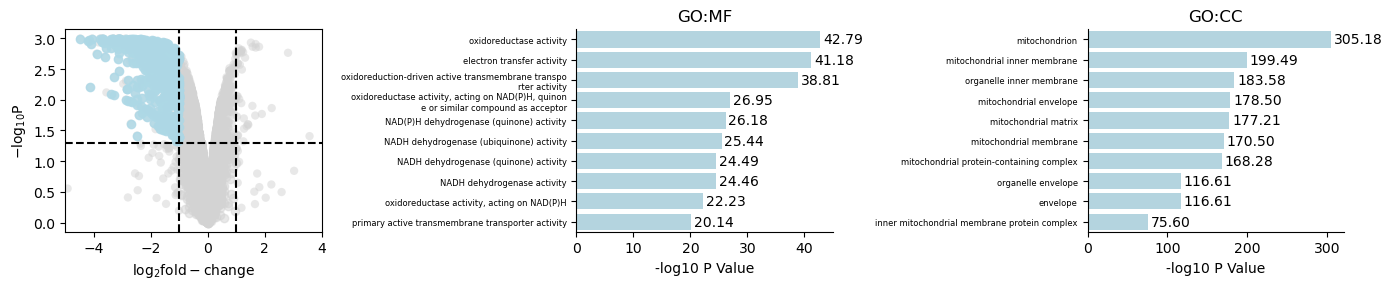

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 3))

axs[0].set_xlim(-5, 4)

# this wrapper function produces the actual volcano plot
vis.volcano(
    pg,
    log_fc_colname="logFC_limma",  # colname from which the x values are taken
    p_colname="adj.P.Val_limma",  # same for the y values
    log_fc_thresh=1,  # a threshold of 4-fold enrichment is typically chosen
    kwargs_both_sig={"color": "lightgrey", "edgecolor": "none"},
    kwargs_p_sig={"color": "lightgrey", "edgecolor": "none"},
    kwargs_log_fc_sig={"color": "lightgrey", "edgecolor": "none"},
    show_legend=False,
    show_caption=False,
    annotate=None,
    highlight=signficantly_downregulated,
    kwargs_highlight={"color": "lightblue"},
    ax=axs[0],
)

sns.barplot(
    data=go_annot[go_annot["source"] == "GO:MF"].head(10),
    x="-log10 P Value",
    y="name",
    color="lightblue",
    ax=axs[1],
)

axs[1].bar_label(axs[1].containers[0], fmt="%.2f", padding=2)
axs[1].set_ylabel(None)
axs[1].set_title("GO:MF")
axs[1].yaxis.set_tick_params(labelsize=6)
axs[1].yaxis.set_ticklabels(
    [
        re.sub("(.{50})", "\\1\n", label.get_text(), 0, re.DOTALL)
        for label in axs[1].yaxis.get_ticklabels()
    ]
)
sns.despine(ax=axs[1])

sns.barplot(
    data=go_annot[go_annot["source"] == "GO:CC"].head(10),
    x="-log10 P Value",
    y="name",
    color="lightblue",
    ax=axs[2],
)

axs[2].bar_label(axs[2].containers[0], fmt="%.2f", padding=2)
axs[2].set_ylabel(None)
axs[2].set_title("GO:CC")

axs[2].yaxis.set_tick_params(labelsize=6)
axs[2].yaxis.set_ticklabels(
    [
        re.sub("(.{50})", "\\1\n", label.get_text(), 0, re.DOTALL)
        for label in axs[2].yaxis.get_ticklabels()
    ]
)
sns.despine(ax=axs[2])

plt.tight_layout()
plt.savefig("importomics_fig5.pdf")
plt.show()